In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import pickle
import torch
import torch.nn as nn

In [43]:
dir00 = '/home/watson/Documents/CIFAR/cifar-10-python/cifar-10-batches-py/cifar-10-batches-py/small_alexnet'
sub_folder = ['true_labels_12-03-2024_19-00-34',
              'corrupt_labels_20_12-03-2024_19-00-33',
              'corrupt_labels_40_12-03-2024_19-00-33',
              'corrupt_labels_60_12-03-2024_19-00-32',
              'corrupt_labels_80_12-03-2024_19-00-38',
              'random_labels_12-02-2024_17-21-21']
file_weights = 'model_weights4950.pth'
file_results = 'file4999.pkl'

In [2]:

dir00 = '/home/watson/Documents/CIFAR/cifar-10-python/cifar-10-batches-py/cifar-10-batches-py/small_inception'
sub_folder = ['true_labels_12-03-2024_19-01-03',
              'corrupt_labels_20_12-03-2024_19-01-03',
              'corrupt_labels_40_12-03-2024_19-01-04',
              'corrupt_labels_60_12-03-2024_19-01-01',
              'corrupt_labels_80_12-03-2024_19-01-01',
              'random_labels_12-02-2024_17-21-40']
file_weights = 'model_weights4950.pth'
file_results = 'file4999.pkl'

In [26]:
class Conv(nn.Module):
    def __init__(self,input_channel,output_channel,kernel_size,stride,padding):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        self.max = nn.MaxPool2d(3, stride=2,padding=0)
        self.localnorm = nn.LocalResponseNorm(5,alpha=1e-4,beta=0.75,k=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.max(x)
        x = self.localnorm(x)
        x = self.relu(x)
        return x
    
class fullconnect(nn.Module):
    def __init__(self,input_channel,output_channel):
        super(fullconnect, self).__init__()
        self.fc = nn.Linear(input_channel,output_channel)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x
    
class AlexnetSmall(nn.Module):
    def __init__(self,input_channel):
        super(AlexnetSmall, self).__init__()
        self.conv1 = Conv(input_channel,128,5,1,2)
        self.conv2 = Conv(128,256,5,1,2)
        self.maxpool = nn.MaxPool2d(3, stride=2)

        self.fc1 = fullconnect(1024,384)
        self.fc2 = fullconnect(384,192)
        self.fc3 = nn.Linear(192, 10)  # 10-way classification

    def forward(self, x):
        x = self.conv1(x)
        # print('conv1 done',x.shape)
        x = self.conv2(x)
        # print('conv2 done',x.shape)
        x = self.maxpool(x)
        # print('max pool is done',x.shape)
        x = torch.flatten(x,1)
        # print('x dimension after flattening',x.shape)
        x = self.fc1(x)
        # print('fc1 done')
        x = self.fc2(x)
        # print('fc2 done')
        x = self.fc3(x)
        # print('fc3 done')
        return x

In [3]:
class Conv(nn.Module):
    def __init__(self,input_channel,output_channel,kernel_size,stride,padding):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(output_channel) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
    
class Inception(nn.Module):
    def __init__(self, input_channel, output1, output3):
        super(Inception,self).__init__()
        self.branch1 = Conv(input_channel, output1, 1, 1,padding=0)
        self.branch3 = Conv(input_channel, output3, 3, 1,padding=1)

    def forward(self, x):
        b1 = self.branch1(x)  
        b3 = self.branch3(x) 
        # print(b1.shape,b3.shape)
        # Concatenate along the channel dimension
        return torch.cat([b1, b3], dim=1)

class Downsample(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(Downsample,self).__init__()
        self.branch_conv = Conv(input_channel, output_channel, 3, 2,padding=1)
        self.branch_pool = nn.MaxPool2d(3, stride=2,padding=1)

    def forward(self, x):
        b_conv = self.branch_conv(x)  
        b_pool = self.branch_pool(x) 
        # print(b_conv.shape,b_pool.shape)
        # Concatenate along the channel dimension
        return torch.cat([b_conv, b_pool], dim=1)

class InceptionSmall(nn.Module):
    def __init__(self,input_channel):
        super(InceptionSmall, self).__init__()
        self.initial_conv = Conv(input_channel, 96, 3, 1,1)  

        # First Inception Block
        self.inception1 = Inception(96, 32, 32)
        self.inception2 = Inception(64, 32, 48)
        self.downsample1 = Downsample(80, 80)

        # Second Inception Block
        self.inception3 = Inception(160, 112, 48)
        self.inception4 = Inception(160, 96, 64)
        self.inception5 = Inception(160, 80, 80)
        self.inception6 = Inception(160, 48, 96)
        self.downsample2 = Downsample(144, 96)

        # Final Inception Block
        self.inception7 = Inception(240, 176, 160)
        self.inception8 = Inception(336, 176, 160)

        # Classification Head
        self.global_pool = nn.AvgPool2d(7)  # 7x7 kernel global pooling
        self.fc = nn.Linear(336, 10)  # 10-way classification

    def forward(self, x):
        x = self.initial_conv(x)
        # print('initial_conv done')
        x = self.inception1(x)
        # print('inception1 done')
        x = self.inception2(x)
        # print('inception2 done')

        x = self.downsample1(x)
        # print('downsample1 done')
        x = self.inception3(x)
        # print('inception3 done')

        x = self.inception4(x)
        # print('inception4 done')

        x = self.inception5(x)
        # print('inception5 done')

        x = self.inception6(x)
        # print('inception6 done')

        x = self.downsample2(x)
        # print('downsample2 done',x.shape)
        x = self.inception7(x)
        # print('inception7 done')

        x = self.inception8(x)
        # print('inception8 done')

        x = self.global_pool(x)
        # print('global_pool done')
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [4]:
norm = np.zeros(len(sub_folder))
for i in range(len(sub_folder)):
    print(i)
    directory = dir00 + os.sep + sub_folder[i]
    weights_dir = directory + os.sep + file_weights
    results_dir = directory + os.sep + file_results

    with open(results_dir,'rb') as f:
        results = pickle.load(f)
    model = InceptionSmall(3)
    model.load_state_dict(torch.load(weights_dir,weights_only=True))

    for param in model.parameters():
        norm[i] +=np.sum(torch.detach(param).numpy()**2)
norm = norm/np.sqrt(50000)

0
1
2
3
4
5


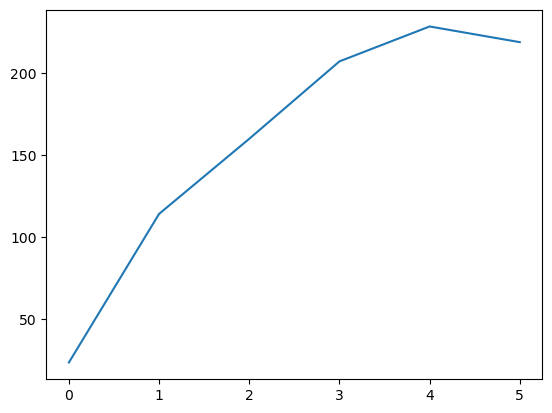

In [5]:
plt.plot(norm)

In [6]:
norm

array([ 23.68882737, 114.25461828, 160.03007391, 207.21161965,
       228.48879965, 218.92818736])